# Final Project

In [68]:
import pandas as pd
import pickle
from fastai.text import *
from fastai import *
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load Data & Construct Databunch object

In [69]:
path = Path('/content/drive/My Drive/Colab Notebooks/Final Project/')
path.ls()

[PosixPath('/content/drive/My Drive/Colab Notebooks/Final Project/IMDB movie review example'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Final Project/Final Project.ipynb'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Final Project/df_work.csv'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/Final Project/output')]

In [0]:
df = pd.read_csv(path/"df_work.csv", index_col=0)

In [71]:
data_lm = (TextList.from_df(df, path=path, cols='TEXT')
           .split_by_rand_pct(seed=67)
           .label_for_lm()
           .databunch(bs=64, num_workers=2))  # batchsize = 64

In [72]:
len(data_lm.vocab.itos), len(data_lm.train_ds)

(19984, 9898)

In [0]:
new_path = path/'output'

In [0]:
data_lm.save(new_path/'lm_data')

In [0]:
data_lm = load_data(new_path,'lm_data')

In [76]:
data_lm.show_batch()

idx,text
0,"orders being placed . xxmaj typically purchase orders outstanding with delivery dates within 30 days are non - cancelable . xxmaj therefore , only approximately 55 percent of our reported purchase commitments arising from these agreements are firm , non - cancelable , and unconditional commitments . xxmaj we expect to fulfill most of our purchase commitments for inventory within one year . xxmaj in addition to the above mentioned"
1,". xxmaj for purposes of estimating the fair value of each stock option unit on the date of grant , we utilized the xxmaj black - xxmaj scholes option - pricing model . xxmaj the xxmaj black - xxmaj scholes option valuation model was developed for use in estimating the fair value of traded options , which have no vesting restrictions and are fully transferable . xxmaj in addition ,"
2,( 469 ) ( 411 ) xxmaj basic loss per share ( 0.04 ) ( 0.12 ) ( 0.11 ) ( 0.07 ) ( 0.01 ) ( 0.03 ) ( 0.06 ) ( 0.05 ) xxmaj diluted loss per share ( 0.04 ) ( 0.12 ) ( 0.11 ) ( 0.07 ) ( 0.01 ) ( 0.03 ) ( 0.06 ) ( 0.05 ) xxmaj earnings per share is computed
3,", which primarily services most of the programming networks included in the xxmaj national xxmaj networks segment . xxmaj international and xxmaj other : xxmaj principally includes xxup amc xxmaj networks xxmaj international , the xxmaj company s international programming businesses consisting of a portfolio of channels in xxmaj europe , xxmaj latin xxmaj america , the xxmaj middle xxmaj east and parts of xxmaj asia and xxmaj africa ;"
4,"with finite lives upon significant changes in the xxmaj company s business environment . xxmaj the testing resulted in approximately $ 33,000 , $ 45,000 , and $ 275,000 of patent impairment charges during the years ended xxmaj december 31 , 2013 , 2012 , and 2011 respectively . xxmaj long - xxmaj lived xxmaj assets : xxmaj the xxmaj company records property and equipment at cost . xxmaj depreciation"


## 2. Finetune Language Model 

### Construct Language Model learner using AWD_LSTM model.


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

### Test the Language Model Learner.

In [0]:
vocab = data_lm.vocab

In [0]:
TEXT = "The company stock drops because"
N_WORDS = 30
N_SENTENCES = 2

In [82]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The company stock drops because of the lack of money to buy out different companies . The company was later converted to a sales software company , but lost its products . During
The company stock drops because of the increase in prices and launch rates , and the loss of the company 's equipment . The company then sold the company to American Chemical


### Finetune the Language Model Learner to the texts in the 10-K forms in our data.

In [83]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


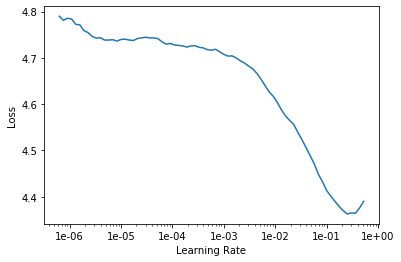

In [84]:
learn_lm.recorder.plot(skip_end=15)

In [0]:
lr = 1e-3   # set learning rate according to the plot

In [0]:
learn_lm.to_fp16();

In [101]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.891466,2.302822,0.571429,03:17


In [0]:
learn_lm.save(new_path/'fit_1')

In [0]:
learn_lm.load(new_path/'fit_1');

In [0]:
learn_lm.unfreeze()

In [105]:
learn_lm.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.840808,2.275537,0.585714,03:16
1,1.656230,2.200438,0.571429,03:16
2,1.563748,2.167121,0.600000,03:18
3,1.413669,2.121336,0.585714,03:17
4,1.333790,2.131405,0.585714,03:18


The 1st, 4th, and 5th epochs all have the same highest accuracy, which is 0.585714.

### Test the finetuned Language Model Learner again.

In [0]:
TEXT = "The company stock drops because"
N_WORDS = 30
N_SENTENCES = 2

In [107]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The company stock drops because the Company has established a policy that allows the Company to issue shares of common stock which enables the Company to realize the expected stock price volatility
The company stock drops because the Company s policy has been consistently applied . This model requires the Company to use estimates of future cash flows , including stock price volatility ,


Save the finetuned model, which will be used as encoder.

In [0]:
learn_lm.save(new_path/'fine_tuned')
learn_lm.save_encoder(new_path/'fine_tuned_enc')

## 3. Stock Performance Classification

- We will classify the performance of the company's stock for 1 day, 1 week, and 2 weeks. 

### Load the finetuned encoder.

In [109]:
learn_lm.load(new_path/'fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9898 items)
x: LMTextList
xxbos suppliers and use several contract manufacturers to provide manufacturing services for our products . xxmaj during the normal course of business , we issue purchase orders with estimates of our requirements several months ahead of the delivery dates . xxmaj however , our agreements with these suppliers usually provide us the option to cancel , reschedule , and adjust our requirements based on our business needs prior to firm orders being placed . xxmaj typically purchase orders outstanding with delivery dates within 30 days are non - cancelable . xxmaj therefore , only approximately 55 percent of our reported purchase commitments arising from these agreements are firm , non - cancelable , and unconditional commitments . xxmaj we expect to fulfill most of our purchase commitments for inventory within one year . xxmaj in addition to the above mentioned commitments to contract manufacturers and suppli

### (1) 1-Day Classification Model 
- Model for the stock performance 1 day after the release of the 10-K form

In [110]:
data_clf = (TextList.from_df(df, path=path, cols='TEXT')
           .split_by_rand_pct(seed=67)
           .label_from_df(cols='PERF_1D',label_cls=CategoryList)
           .databunch(bs=64, num_workers=2))

In [111]:
data_clf.show_batch()

text,target
xxbos xxup llc 5 / 1 / 2015 4 / 30 / 2030 480 xxmaj eaglewood xxup xxunk xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 xxmaj eaglewood xxmaj care xxmaj center xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 h c of xxmaj xxunk xxmaj beacon xxmaj health xxmaj management 8,1
"xxbos enforcement programs : 4 g xxmaj wireless technology ( 1 ) xxmaj messaging technology xxmaj application xxmaj authentication technology ( 1 ) xxmaj minimally xxmaj xxunk xxmaj surgery technology ( 1)(2 ) xxmaj audio xxmaj communications xxmaj fraud xxmaj detection technology xxmaj mobile xxmaj computer xxmaj synchronization technology xxmaj automotive xxmaj safety , xxmaj navigation and xxmaj diagnostics technology ( 1 ) xxmaj network xxmaj monitoring technology xxmaj bone",0
xxbos 6 / 17 / 2015 0.51563 8.25 % xxmaj series a 8 / 14 / 2015 8 / 31 / 2015 9 / 17 / 2015 0.51563 8.25 % xxmaj series a 11 / 13 / 2015 11 / 30 / 2015 12 / 17 / 2015 0.51563 xxmaj dividend xxmaj declaration xxmaj date xxmaj record xxmaj date xxmaj payment xxmaj date xxmaj dividend xxmaj per xxmaj share 8.00,-1
"xxbos projected future taxable income , potential tax - planning strategies , and projected future reversals of deferred tax items . xxmaj these assessments are subjective and may change . xxmaj based on these criteria , and in particular our projections for future taxable income , we currently believe that it is more - likely - than - not that we will realize our net deferred tax asset in future",0
"xxbos on industry data of loans of similar type segregated by year of origination , to the extent applicable , and estimated loss severity based on current loss rates for similar loans , our historical rescission rates and the current pipeline of unresolved demands . xxmaj our historical loss severity considers the historical loss experience that we incur upon sale or liquidation of a repurchased loan as well as current",1


In [0]:
learn_c1 = text_classifier_learner(data_clf, AWD_LSTM, drop_mult=0.3)   #.to_fp16()
learn_c1.load_encoder(new_path/'fine_tuned_enc')
learn_c1.freeze()

In [115]:
learn_c1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


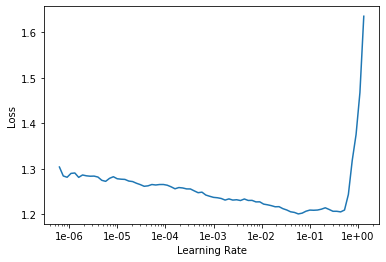

In [116]:
learn_c1.recorder.plot()

In [0]:
lr = 1e-3   # set learning rate according to the plot

In [118]:
learn_c1.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.162032,1.086996,0.428860,01:10
1,1.087392,1.057042,0.451496,01:10
2,1.029701,1.044737,0.461601,01:09
3,1.007576,1.050638,0.467664,01:08
4,0.988402,1.016719,0.474939,01:09
5,0.974206,1.025467,0.470897,01:09
6,0.950541,1.022957,0.489491,01:08
7,0.932153,1.026013,0.485044,01:09
8,0.923151,1.031669,0.489087,01:07
9,0.902353,1.023295,0.479386,01:08


The 7th epoch has the highest accuracy, which is 0.489491.

In [0]:
learn_c1.save(new_path/'1day_1st')

Try some other learning rates.

In [123]:
learn_c1.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.978392,1.031522,0.474939,01:07


In [122]:
learn_c1.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.019920,1.024831,0.476960,01:08


The results are not better than before, so we use the saved 1day_1st model.

### (2) 1-Week Classification Model 
- Model for the stock performance 1 week after the release of the 10-K form

In [124]:
data_clf = (TextList.from_df(df, path=path, cols='TEXT')
           .split_by_rand_pct(seed=67)
           .label_from_df(cols='PERF_1W',label_cls=CategoryList)
           .databunch(bs=64, num_workers=2))

In [125]:
data_clf.show_batch()

text,target
xxbos xxup llc 5 / 1 / 2015 4 / 30 / 2030 480 xxmaj eaglewood xxup xxunk xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 xxmaj eaglewood xxmaj care xxmaj center xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 h c of xxmaj xxunk xxmaj beacon xxmaj health xxmaj management 8,1
"xxbos enforcement programs : 4 g xxmaj wireless technology ( 1 ) xxmaj messaging technology xxmaj application xxmaj authentication technology ( 1 ) xxmaj minimally xxmaj xxunk xxmaj surgery technology ( 1)(2 ) xxmaj audio xxmaj communications xxmaj fraud xxmaj detection technology xxmaj mobile xxmaj computer xxmaj synchronization technology xxmaj automotive xxmaj safety , xxmaj navigation and xxmaj diagnostics technology ( 1 ) xxmaj network xxmaj monitoring technology xxmaj bone",-1
xxbos 6 / 17 / 2015 0.51563 8.25 % xxmaj series a 8 / 14 / 2015 8 / 31 / 2015 9 / 17 / 2015 0.51563 8.25 % xxmaj series a 11 / 13 / 2015 11 / 30 / 2015 12 / 17 / 2015 0.51563 xxmaj dividend xxmaj declaration xxmaj date xxmaj record xxmaj date xxmaj payment xxmaj date xxmaj dividend xxmaj per xxmaj share 8.00,1
"xxbos projected future taxable income , potential tax - planning strategies , and projected future reversals of deferred tax items . xxmaj these assessments are subjective and may change . xxmaj based on these criteria , and in particular our projections for future taxable income , we currently believe that it is more - likely - than - not that we will realize our net deferred tax asset in future",1
"xxbos on industry data of loans of similar type segregated by year of origination , to the extent applicable , and estimated loss severity based on current loss rates for similar loans , our historical rescission rates and the current pipeline of unresolved demands . xxmaj our historical loss severity considers the historical loss experience that we incur upon sale or liquidation of a repurchased loan as well as current",1


In [0]:
learn_c2 = text_classifier_learner(data_clf, AWD_LSTM, drop_mult=0.3) #.to_fp16()
learn_c2.load_encoder(new_path/'fine_tuned_enc')
learn_c2.freeze()

In [127]:
learn_c2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


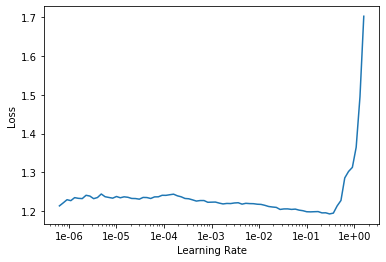

In [128]:
learn_c2.recorder.plot()

In [0]:
lr = 5e-3   # set learning rate according to the plot

In [131]:
learn_c2.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.130805,1.091971,0.420776,01:10
1,1.053501,1.046720,0.437753,01:09
2,1.042528,1.042613,0.436136,01:09
3,1.031996,1.049541,0.431285,01:08
4,1.018730,1.038823,0.444220,01:09
5,1.012812,1.040935,0.434115,01:09
6,0.988639,1.053175,0.427648,01:08
7,0.961860,1.059370,0.427243,01:08
8,0.936594,1.085965,0.430881,01:07
9,0.925221,1.066486,0.426839,01:08


The 5th epoch has the highest accuracy, which is 0.444220.

In [0]:
learn_c2.save(new_path/'1week_1st')

### (2) 2-Week Classification Model 
- Model for the stock performance 2 weeks after the release of the 10-K form

In [146]:
data_clf = (TextList.from_df(df, path=path, cols='TEXT')
           .split_by_rand_pct(seed=67)
           .label_from_df(cols='PERF_2W',label_cls=CategoryList)
           .databunch(bs=64, num_workers=2))

In [147]:
data_clf.show_batch()

text,target
xxbos xxup llc 5 / 1 / 2015 4 / 30 / 2030 480 xxmaj eaglewood xxup xxunk xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 xxmaj eaglewood xxmaj care xxmaj center xxmaj beacon xxmaj health xxmaj management 8 / 1 / 2015 7 / 31 / 2025 720 h c of xxmaj xxunk xxmaj beacon xxmaj health xxmaj management 8,0
"xxbos enforcement programs : 4 g xxmaj wireless technology ( 1 ) xxmaj messaging technology xxmaj application xxmaj authentication technology ( 1 ) xxmaj minimally xxmaj xxunk xxmaj surgery technology ( 1)(2 ) xxmaj audio xxmaj communications xxmaj fraud xxmaj detection technology xxmaj mobile xxmaj computer xxmaj synchronization technology xxmaj automotive xxmaj safety , xxmaj navigation and xxmaj diagnostics technology ( 1 ) xxmaj network xxmaj monitoring technology xxmaj bone",1
xxbos 6 / 17 / 2015 0.51563 8.25 % xxmaj series a 8 / 14 / 2015 8 / 31 / 2015 9 / 17 / 2015 0.51563 8.25 % xxmaj series a 11 / 13 / 2015 11 / 30 / 2015 12 / 17 / 2015 0.51563 xxmaj dividend xxmaj declaration xxmaj date xxmaj record xxmaj date xxmaj payment xxmaj date xxmaj dividend xxmaj per xxmaj share 8.00,0
"xxbos projected future taxable income , potential tax - planning strategies , and projected future reversals of deferred tax items . xxmaj these assessments are subjective and may change . xxmaj based on these criteria , and in particular our projections for future taxable income , we currently believe that it is more - likely - than - not that we will realize our net deferred tax asset in future",1
"xxbos on industry data of loans of similar type segregated by year of origination , to the extent applicable , and estimated loss severity based on current loss rates for similar loans , our historical rescission rates and the current pipeline of unresolved demands . xxmaj our historical loss severity considers the historical loss experience that we incur upon sale or liquidation of a repurchased loan as well as current",1


In [0]:
learn_c3 = text_classifier_learner(data_clf, AWD_LSTM, drop_mult=0.3) #.to_fp16() 
learn_c3.load_encoder(new_path/'fine_tuned_enc')
learn_c3.freeze()

In [149]:
learn_c3.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


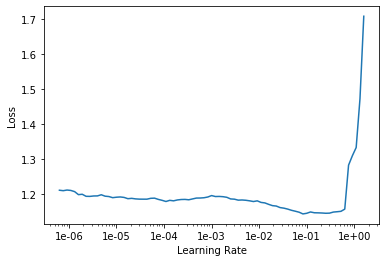

In [150]:
learn_c3.recorder.plot()

In [0]:
lr = 5e-3   # set learning rate according to the plot

In [152]:
learn_c3.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.088822,1.040307,0.433306,01:10
1,1.017981,1.018048,0.464834,01:09
2,0.993062,0.997974,0.470897,01:09
3,0.983364,1.019694,0.466855,01:08
4,0.972454,1.003678,0.468876,01:09
5,0.971872,1.000222,0.466451,01:09
6,0.946927,1.011721,0.461601,01:08
7,0.916791,1.024168,0.467259,01:08
8,0.889226,1.039986,0.469281,01:07
9,0.878427,1.031930,0.469281,01:08


The 3th epoch has the highest accuracy, which is 0.470897.

In [0]:
learn_c3.save(new_path/'2week_1st')

## Results

According to above classification results, the accuracy for each model is shown as below:

- (1) **1 day**: the 7th epoch has the highest accuracy, which is 0.489491.
- (2) **1 week**: the 5th epoch has the highest accuracy, which is 0.444220.
- (3) **2 weeks**: the 3th epoch has the highest accuracy, which is 0.470897.

Therefore, we can see that the 1-day model has the best performance, i.e. highest accuracy, followed by 2-week model. And the 1-week model has the worst performance. However, all the three models have accuracies that are much higher than a random model whose accuracy would be only about 0.33.

As a result, we may conclude that the texts in the 10-K forms can be used to predict the performance of the company's stock performance after the release of the 10-K forms. And it provides the best prediction for the stock performance 1 day after releasing 10-K forms.